# K-MEANS clustering 

# Features of the cyclists

In [51]:
import copy
from os import path

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering, OPTICS
from sklearn.model_selection import ParameterSampler
import pandas as pd
import numpy as np
import seaborn

from transformations import center_and_scale

# show all elements of a dataframe
# pandas.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)



## Hyperparameter search for K-Means

In [52]:
# since several algorithms are randomized, we set a seed to repeat them
RANDOM_STATE = 42

# load dataset
datasetname = path.join('..','dataset', 'cyclists_final_enhanced.csv')
cyclists=pd.read_csv(datasetname)
numeric_dataset = cyclists.select_dtypes(include="number")
normalized_df, normalization_scalers_df = center_and_scale(numeric_dataset)

In [53]:
# Computing sample densities (retained for reference but not used for KMeans)
maximum_distance = abs(normalized_df.max() - normalized_df.min()).sum().item()
average_concentration = normalized_df.shape[0] / maximum_distance

# Set model space with only KMeans
base_algorithms = [KMeans]
base_algorithms_names = ["kmeans"]

# Hyperparameters specific to KMeans
hyperparameters_per_algorithm = [
    {
        "n_clusters": list(range(2, 8)) + [16, 32],  # Number of clusters to evaluate
        "max_iter": [10],                            # Maximum number of iterations
        "random_state": [RANDOM_STATE],              # Random state for reproducibility
        "n_init": [10]                               # Number of initialization runs for stability
    }
]

results_per_algorithm = list()
fit_models = list()
clusterings = list()

# Loop over KMeans algorithm
for algorithm, algorithm_name, hyperparameters in zip(base_algorithms, base_algorithms_names, hyperparameters_per_algorithm):
    # Setup hyperparameter sampling
    sampled_hyperparameters = list(ParameterSampler(
        copy.deepcopy(hyperparameters),
        n_iter=5,  # Number of configurations to sample
        random_state=RANDOM_STATE
    ))
    # Fit the model for each sampled hyperparameter configuration
    models = [
        algorithm(**selected_hyperparameters).fit(normalized_df.values)
        for selected_hyperparameters in sampled_hyperparameters
    ]
    clusterings += [
        model.labels_
        for model in models
    ]
    fit_models += models

    # Store configurations
    for fit_model, selected_hyperparameters in zip(models, sampled_hyperparameters):
        selected_hyperparameters["algorithm"] = algorithm_name
        if hasattr(fit_model, "n_clusters"):
            selected_hyperparameters["n_clusters"] = fit_model.n_clusters
        else:
            selected_hyperparameters["n_clusters"] = selected_hyperparameters.get("n_clusters", 0)
    results_per_algorithm += sampled_hyperparameters

# Create a DataFrame to store results
results_df = pd.DataFrame.from_records(results_per_algorithm)
results_df.loc[:, "random_state"] = RANDOM_STATE

# Clean extra hyperparameters
results_df.loc[results_df["max_iter"].isna(), "max_iter"] = -1
results_df.loc[results_df["n_init"].isna(), "n_init"] = -1
results_df = results_df.astype({"n_clusters": int, "random_state": int})

results_df


,random_state,n_init,n_clusters,max_iter,algorithm
0,42,10,3,10,kmeans
1,42,10,7,10,kmeans
2,42,10,2,10,kmeans
3,42,10,32,10,kmeans
4,42,10,4,10,kmeans


## Evaluation

In [54]:
silhouette_per_model = [
    silhouette_score(normalized_df, clustering) if len(set(clustering)) > 1 else -1
    for clustering in clusterings
]
results_df.loc[:, "silhouette"] = silhouette_per_model
results_df = results_df.sort_values(by="silhouette", ascending=False)
results_df

,random_state,n_init,n_clusters,max_iter,algorithm,silhouette
2,42,10,2,10,kmeans,0.285792
4,42,10,4,10,kmeans,0.222714
0,42,10,3,10,kmeans,0.222235
1,42,10,7,10,kmeans,0.187506
3,42,10,32,10,kmeans,0.150502


## Cohesion

In [55]:
from scipy.spatial.distance import cdist


clusterings_cohesions = list()
for i, clustering in enumerate(clusterings):
    clusters_indices = [np.argwhere(clustering == target_cluster).squeeze()
                        for target_cluster in np.unique(clustering)]
    centroids = [normalized_df.values[cluster].mean(axis=0)
                 for cluster in clusters_indices]
    mean_distances = [sum(cdist([centroid], normalized_df.values[indices]).squeeze()).item()
                      for centroid, indices in zip(centroids, clusters_indices) if centroid.ndim > 0]
    clusterings_cohesions.append(mean_distances)

summed_cohesions = [sum(cohesion) for cohesion in clusterings_cohesions]
results_df.loc[:, "cohesion"] = summed_cohesions
results_df.sort_values(by="silhouette")

,random_state,n_init,n_clusters,max_iter,algorithm,silhouette,cohesion
3,42,10,32,10,kmeans,0.150502,12854.596629
1,42,10,7,10,kmeans,0.187506,7955.479395
0,42,10,3,10,kmeans,0.222235,14680.562115
4,42,10,4,10,kmeans,0.222714,11056.371468
2,42,10,2,10,kmeans,0.285792,13308.124411


<Axes: xlabel='n_clusters', ylabel='silhouette'>

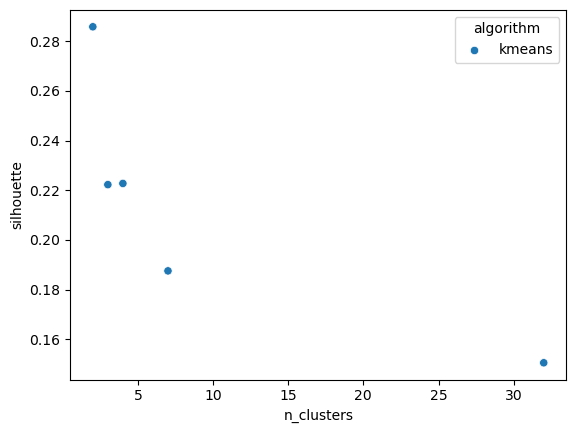

In [56]:
import seaborn


seaborn.scatterplot(
    results_df,
    x="n_clusters",
    y="silhouette",
    hue="algorithm"
)

## How do clusters relate with original data?

In [57]:
reference_clustering_index = 4
reference_clustering = clusterings[reference_clustering_index]
clustering_dataframe = pd.DataFrame(reference_clustering, columns=["clustering"])
dataset_with_clustering = pd.concat((cyclists, clustering_dataframe), axis="columns")

# for simplicity, only show a subset of the data
dataset_with_clustering = dataset_with_clustering.iloc[:reference_clustering.size, :]

dataset_with_clustering = dataset_with_clustering.astype({"clustering": int})
dataset_with_clustering.head()

,_url,name,birth_year,weight,height,nationality,bmi,career_points,career_duration(days),career_duration(races),debut_year,avg_pos,clustering
0,bruno-surra,Bruno Surra,1964,73.0,185,Italy,21.329438,80.0,1.0,1.0,1989.0,110.000000,0
1,gerard-rue,Gérard Rué,1965,74.0,182,France,22.340297,26105.0,3492.0,222.0,1988.0,63.545045,3
2,jan-maas,Jan Maas,1996,69.0,189,Netherlands,19.316369,4425.0,519.0,49.0,2022.0,87.693878,0
3,nathan-van-hooydonck,Nathan Van Nathan Van Hooydonck,1995,78.0,192,Belgium,21.158854,17205.0,1982.0,161.0,2018.0,83.242236,0
4,jose-felix-parra,José Félix Parra,1997,55.0,171,Spain,18.809206,3085.0,721.0,48.0,2021.0,68.000000,0


In [58]:
clusters_sizes = np.unique(reference_clustering, return_counts=True)[1]
average_cyclist_per_cluster = dataset_with_clustering.groupby("clustering")\
    .describe()\
    .xs(                  # select from a multi-index dataframe
        "mean",           # which columns to select?
        level=1,          # at what level of the index?
        drop_level=True,  
        axis="columns"
    )
average_cyclist_per_cluster.loc[:, "cluster_size"] = clusters_sizes
std_cyclist_per_cluster = dataset_with_clustering.groupby("clustering")\
    .describe()\
    .xs(                  # select from a multi-index dataframe
        "std",           # which columns to select?
        level=1,          # at what level of the index?
        drop_level=True,  
        axis="columns"
    )
std_cyclist_per_cluster.loc[:, "cluster_size"] = clusters_sizes


average_cyclist_per_cluster


,birth_year,weight,height,bmi,career_points,career_duration(days),career_duration(races),debut_year,avg_pos,cluster_size
clustering,,,,,,,,,,
0,1983.301799,68.444437,180.208861,21.055637,3731.795602,956.431046,44.897069,2007.882079,97.864823,3002
1,1957.406019,68.860665,179.201162,21.433876,3104.091430,1149.440866,28.348469,1982.323654,44.874447,1894
2,1979.974359,67.564103,179.333333,20.986503,0.000000,0.000000,0.000000,0.000000,-1.000000,39
3,1977.014178,68.617598,179.727273,21.222999,29646.972607,4109.427023,334.772310,2000.203503,72.251112,1199


In [59]:
std_cyclist_per_cluster

,birth_year,weight,height,bmi,career_points,career_duration(days),career_duration(races),debut_year,avg_pos,cluster_size
clustering,,,,,,,,,,
0,11.475233,6.217838,6.311213,1.322656,4152.114220,989.817477,50.424189,10.844148,24.428771,3002
1,9.068699,5.906739,6.125486,1.393106,4246.357216,1195.713827,40.651808,8.760130,24.405150,1894
2,11.741710,6.340326,5.521886,1.445792,0.000000,0.000000,0.000000,0.000000,0.000000,39
3,10.387997,6.037060,6.069012,1.286628,12494.562218,1074.229861,145.030464,10.254945,20.206904,1199


## What features are relevant to clustering

In [60]:
average_cyclist_per_cluster.std().sort_values()

bmi                           0.199248
height                        0.453081
weight                        0.564818
birth_year                   11.632462
avg_pos                      42.286688
career_duration(races)      156.282054
debut_year                  998.458956
cluster_size               1242.560931
career_duration(days)      1776.314527
career_points             13781.084922
dtype: float64

## Clustering Preprocessing

In [61]:
cyclists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   _url                    6134 non-null   object 
 1   name                    6134 non-null   object 
 2   birth_year              6134 non-null   int64  
 3   weight                  6134 non-null   float64
 4   height                  6134 non-null   int64  
 5   nationality             6134 non-null   object 
 6   bmi                     6134 non-null   float64
 7   career_points           6134 non-null   float64
 8   career_duration(days)   6134 non-null   float64
 9   career_duration(races)  6134 non-null   float64
 10  debut_year              6134 non-null   float64
 11  avg_pos                 6134 non-null   float64
dtypes: float64(7), int64(2), object(3)
memory usage: 575.2+ KB


In [62]:
# since several algorithms are randomized, we set a seed to repeat them
RANDOM_STATE = 42

# load dataset
datasetname = path.join('..','dataset', 'cyclists_final_enhanced.csv')
cyclists = pd.read_csv(datasetname)
num_columns = ['bmi', 'height', 'weight', 'birth_year', 'avg_pos', 'career_duration(races)', 'debut_year', 'career_duration(days)', 'career_points']
cat_columns = ['nationality']
df = cyclists.copy()
numeric_dataset = df[num_columns]
cat_dataset = df[cat_columns]

In [63]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler.fit(numeric_dataset)
X = scaler.transform(numeric_dataset)

In [64]:
pd.DataFrame(scaler.inverse_transform(scaler.transform(numeric_dataset)), columns=numeric_dataset.columns)

,bmi,height,weight,birth_year,avg_pos,career_duration(races),debut_year,career_duration(days),career_points
0,21.329438,185.0,73.0,1964.0,110.000000,1.0,1989.0,1.0,80.0
1,22.340297,182.0,74.0,1965.0,63.545045,222.0,1988.0,3492.0,26105.0
2,19.316369,189.0,69.0,1996.0,87.693878,49.0,2022.0,519.0,4425.0
3,21.158854,192.0,78.0,1995.0,83.242236,161.0,2018.0,1982.0,17205.0
4,18.809206,171.0,55.0,1997.0,68.000000,48.0,2021.0,721.0,3085.0
...,...,...,...,...,...,...,...,...,...
6129,19.350208,179.0,62.0,1966.0,10.000000,1.0,1993.0,1.0,80.0
6130,21.220009,188.0,75.0,1998.0,84.576923,26.0,2020.0,1140.0,2410.0
6131,20.451146,181.0,67.0,1973.0,106.500000,12.0,1997.0,311.0,955.0
6132,20.069204,170.0,58.0,1985.0,71.929204,113.0,2009.0,1849.0,8920.0


In [65]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [66]:
kmeans = KMeans(
    n_clusters=4,         
    random_state=42,      
    max_iter=10           
)
kmeans.fit(X)

KMeans(max_iter=10, n_clusters=4, random_state=42)

In [67]:
kmeans.labels_[:5]

array([0, 2, 3, 0, 3], dtype=int32)

In [68]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([1760, 1453, 1010, 1911]))

In [69]:
kmeans.cluster_centers_

array([[ 0.54638132,  0.71914064,  0.95672411,  0.33471448,  0.4832102 ,
        -0.28352584,  0.112849  , -0.18177989, -0.28364294],
       [ 0.07738134, -0.10827698, -0.04021742, -1.17529415, -1.18014506,
        -0.52675517, -0.36701046, -0.37969118, -0.4928471 ],
       [-0.01820975, -0.04226825, -0.04841513,  0.19031919, -0.15652178,
         1.89394553,  0.09041946,  1.61999502,  1.9025657 ],
       [-0.54320189, -0.5465171 , -0.80966233,  0.486427  ,  0.53702823,
        -0.33499498,  0.12817127, -0.39506102, -0.36503155]])

In [70]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)

## Clusterings of the features linked to the physical characteristics of the cyclists

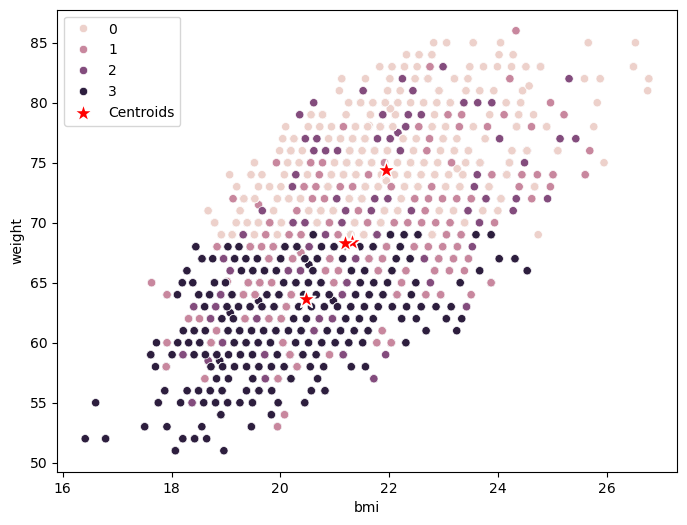

In [71]:
import matplotlib.pyplot as plt
# Create a single plot
plt.figure(figsize=(8, 6))

# Second scatter plot: for the numeric_dataset with KMeans labels
seaborn.scatterplot(data=numeric_dataset, x="bmi", y="weight", hue=kmeans.labels_)

# Plot the NumPy data with a different marker style
seaborn.scatterplot(x=centers[:,0], y=centers[:, 2], label='Centroids', s=200, marker='*', c='r')


# Add labels and title
plt.xlabel('bmi')
plt.ylabel('weight')

# Display the plot
plt.legend()
plt.show()

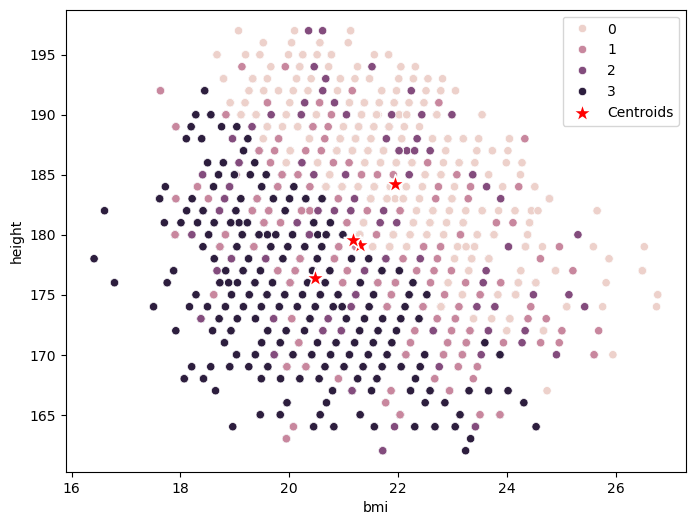

In [72]:
import matplotlib.pyplot as plt
# Create a single plot
plt.figure(figsize=(8, 6))

# Second scatter plot: for the numeric_dataset with KMeans labels
seaborn.scatterplot(data=numeric_dataset, x="bmi", y="height", hue=kmeans.labels_)

# Plot the NumPy data with a different marker style
seaborn.scatterplot(x=centers[:,0], y=centers[:, 1], label='Centroids', s=200, marker='*', c='r')


# Add labels and title
plt.xlabel('bmi')
plt.ylabel('height')

# Display the plot
plt.legend()
plt.show()

## Clustering of the features linked to the performance of the cyclists

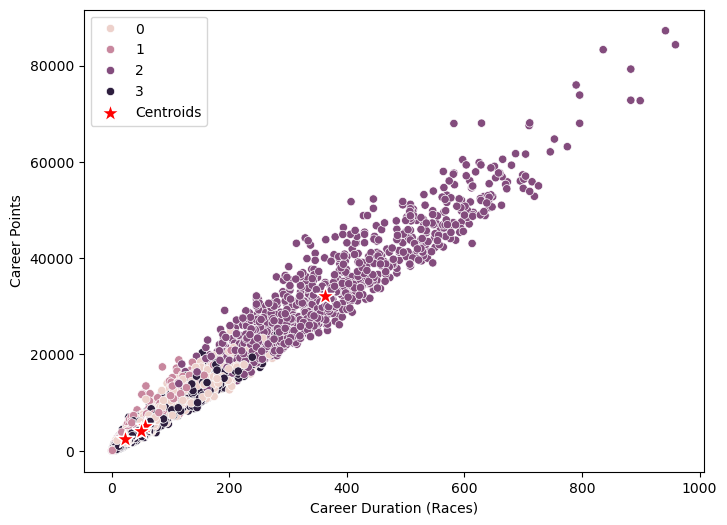

In [73]:
import matplotlib.pyplot as plt
# Create a single plot
plt.figure(figsize=(8, 6))

# Second scatter plot: for the numeric_dataset with KMeans labels
seaborn.scatterplot(data=numeric_dataset, x="career_duration(races)", y="career_points", hue=kmeans.labels_)

# Plot the NumPy data with a different marker style
seaborn.scatterplot(x=centers[:,5], y=centers[:, 8], label='Centroids', s=200, marker='*', c='r')


# Add labels and title
plt.xlabel('Career Duration (Races)')
plt.ylabel('Career Points')

# Display the plot
plt.legend()
plt.show()

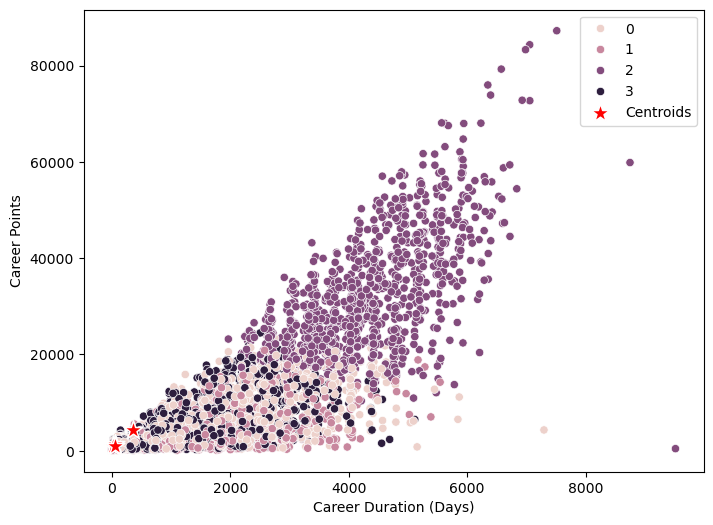

In [74]:
import matplotlib.pyplot as plt
# Create a single plot
plt.figure(figsize=(8, 6))

# Second scatter plot: for the numeric_dataset with KMeans labels
seaborn.scatterplot(data=numeric_dataset, x="career_duration(days)", y="career_points", hue=kmeans.labels_)

# Plot the NumPy data with a different marker style
seaborn.scatterplot(x=centers[:,5], y=centers[:, 7], label='Centroids', s=200, marker='*', c='r')


# Add labels and title
plt.xlabel('Career Duration (Days)')
plt.ylabel('Career Points')

# Display the plot
plt.legend()
plt.show()

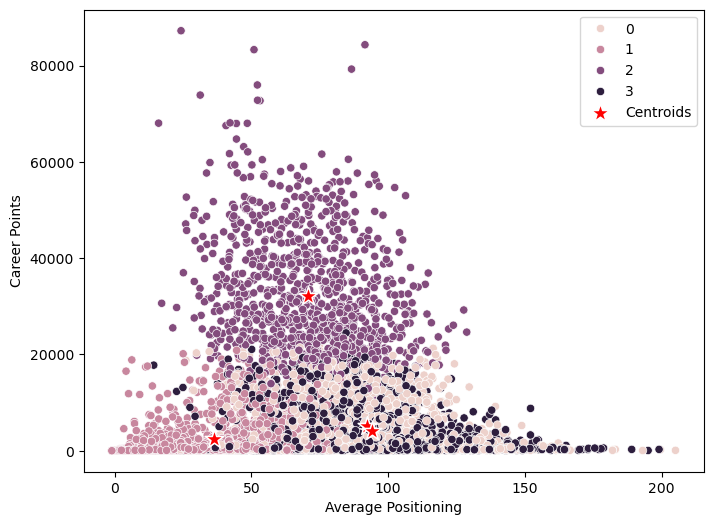

In [75]:
import matplotlib.pyplot as plt
# Create a single plot
plt.figure(figsize=(8, 6))

# Second scatter plot: for the numeric_dataset with KMeans labels
seaborn.scatterplot(data=numeric_dataset, x="avg_pos", y="career_points", hue=kmeans.labels_)

# Plot the NumPy data with a different marker style
seaborn.scatterplot(x=centers[:,4], y=centers[:, 8], label='Centroids', s=200, marker='*', c='r')


# Add labels and title
plt.xlabel('Average Positioning')
plt.ylabel('Career Points')

# Display the plot
plt.legend()
plt.show()

# Features of the races

In [76]:
import copy
from os import path

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering, OPTICS
from sklearn.model_selection import ParameterSampler
import pandas as pd
import numpy as np
import seaborn

from transformations import center_and_scale

# show all elements of a dataframe
# pandas.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

## Clustering preprocessing

In [77]:
# since several algorithms are randomized, we set a seed to repeat them
RANDOM_STATE = 42

# load dataset
datasetname = path.join('..','dataset', 'engineered_races.csv')
cyclists=pd.read_csv(datasetname)
numeric_dataset = cyclists.select_dtypes(include="number")
normalized_df, normalization_scalers_df = center_and_scale(numeric_dataset)

In [78]:
# Computing sample densities (retained for reference but not used for KMeans)
maximum_distance = abs(normalized_df.max() - normalized_df.min()).sum().item()
average_concentration = normalized_df.shape[0] / maximum_distance

# Set model space with only KMeans
base_algorithms = [KMeans]
base_algorithms_names = ["kmeans"]

# Hyperparameters specific to KMeans
hyperparameters_per_algorithm = [
    {
        "n_clusters": list(range(2, 8)) + [16, 32],  # Number of clusters to evaluate
        "max_iter": [10],                            # Maximum number of iterations
        "random_state": [RANDOM_STATE],              # Random state for reproducibility
        "n_init": [10]                               # Number of initialization runs for stability
    }
]

results_per_algorithm = list()
fit_models = list()
clusterings = list()

# Loop over KMeans algorithm
for algorithm, algorithm_name, hyperparameters in zip(base_algorithms, base_algorithms_names, hyperparameters_per_algorithm):
    # Setup hyperparameter sampling
    sampled_hyperparameters = list(ParameterSampler(
        copy.deepcopy(hyperparameters),
        n_iter=5,  # Number of configurations to sample
        random_state=RANDOM_STATE
    ))
    # Fit the model for each sampled hyperparameter configuration
    models = [
        algorithm(**selected_hyperparameters).fit(normalized_df.values)
        for selected_hyperparameters in sampled_hyperparameters
    ]
    clusterings += [
        model.labels_
        for model in models
    ]
    fit_models += models

    # Store configurations
    for fit_model, selected_hyperparameters in zip(models, sampled_hyperparameters):
        selected_hyperparameters["algorithm"] = algorithm_name
        if hasattr(fit_model, "n_clusters"):
            selected_hyperparameters["n_clusters"] = fit_model.n_clusters
        else:
            selected_hyperparameters["n_clusters"] = selected_hyperparameters.get("n_clusters", 0)
    results_per_algorithm += sampled_hyperparameters

# Create a DataFrame to store results
results_df = pd.DataFrame.from_records(results_per_algorithm)
results_df.loc[:, "random_state"] = RANDOM_STATE

# Clean extra hyperparameters
results_df.loc[results_df["max_iter"].isna(), "max_iter"] = -1
results_df.loc[results_df["n_init"].isna(), "n_init"] = -1
results_df = results_df.astype({"n_clusters": int, "random_state": int})

results_df


,random_state,n_init,n_clusters,max_iter,algorithm
0,42,10,3,10,kmeans
1,42,10,7,10,kmeans
2,42,10,2,10,kmeans
3,42,10,32,10,kmeans
4,42,10,4,10,kmeans


## Evaluation

In [ ]:
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed
import pandas as pd


silhouette_per_model = [
    silhouette_score(normalized_df, clustering, sample_size=20000)
    for clustering in clusterings
]

results_df["silhouette"] = silhouette_per_model
results_df = results_df.sort_values(by="silhouette", ascending=False)

results_df


,random_state,n_init,n_clusters,max_iter,algorithm,silhouette
0,42,10,3,10,kmeans,0.175318
1,42,10,7,10,kmeans,0.161084
2,42,10,2,10,kmeans,0.160441
4,42,10,4,10,kmeans,0.157899
3,42,10,32,10,kmeans,0.136593


## Cohesion

In [80]:
from scipy.spatial.distance import cdist


clusterings_cohesions = list()
for i, clustering in enumerate(clusterings):
    clusters_indices = [np.argwhere(clustering == target_cluster).squeeze()
                        for target_cluster in np.unique(clustering)]
    centroids = [normalized_df.values[cluster].mean(axis=0)
                 for cluster in clusters_indices]
    mean_distances = [sum(cdist([centroid], normalized_df.values[indices]).squeeze()).item()
                      for centroid, indices in zip(centroids, clusters_indices) if centroid.ndim > 0]
    clusterings_cohesions.append(mean_distances)

summed_cohesions = [sum(cohesion) for cohesion in clusterings_cohesions]
results_df.loc[:, "cohesion"] = summed_cohesions
results_df.sort_values(by="silhouette")

,random_state,n_init,n_clusters,max_iter,algorithm,silhouette,cohesion
3,42,10,32,10,kmeans,0.136593,1.646764e+06
4,42,10,4,10,kmeans,0.157899,1.102448e+06
2,42,10,2,10,kmeans,0.160441,1.839078e+06
1,42,10,7,10,kmeans,0.161084,1.513562e+06
0,42,10,3,10,kmeans,0.175318,1.749875e+06


## Clustering preprocessing

In [81]:
# since several algorithms are randomized, we set a seed to repeat them
RANDOM_STATE = 42

# load dataset
datasetname = path.join('..','dataset', 'engineered_races.csv')
races = pd.read_csv(datasetname)
num_columns = ['points', 'length', 'climb_total', 'profile', 'startlist_quality', 'position', 'cyclist_age', 'delta', 'climbing_efficiency', 'competitive_age', 'difficulty', 'convenience_score', 'difficulty_score', 'performance_index', 'gain_ratio']
cat_columns = ['cyclist_team', 'difficulty_level', 'std_name', 'stage']
df = races.copy()
numeric_dataset = df[num_columns]
cat_dataset = df[cat_columns]

In [82]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler.fit(numeric_dataset)
X = scaler.transform(numeric_dataset)

In [83]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [84]:
kmeans = KMeans(n_clusters=4, n_init=10, max_iter=10)
kmeans.fit(X)

KMeans(max_iter=10, n_clusters=4, n_init=10)

In [85]:
kmeans.cluster_centers_

array([[-0.33583373,  0.12974487,  0.53232703,  0.62227898, -0.22618918,
        -0.13147351, -0.65134414,  0.19789215, -0.03577549, -0.65144081,
        -0.06553473, -0.29333311,  0.59265882,  0.18126351, -0.12927386],
       [-0.31521175,  0.12669966,  0.34365083,  0.35394951, -0.08723329,
         0.08991024,  1.15939516,  0.15190828, -0.03513877,  1.15941886,
        -0.08172324, -0.27133124,  0.3682376 , -0.08757718, -0.12250346],
       [-0.142165  , -0.54623493, -0.90800772, -0.95464739,  0.3955931 ,
         0.18479985, -0.15020693, -0.31390625,  0.11322837, -0.15016107,
        -0.1797271 ,  0.66248518, -1.05856124, -0.1780068 ,  0.23906448],
       [ 3.061127  ,  1.23096226,  0.21170609, -0.03555299, -0.31213128,
        -0.43601725, -0.07286011, -0.09189957, -0.18772754, -0.07268519,
         1.27423255, -0.51703125,  0.4728248 ,  0.1778685 , -0.00504407]])

In [86]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)

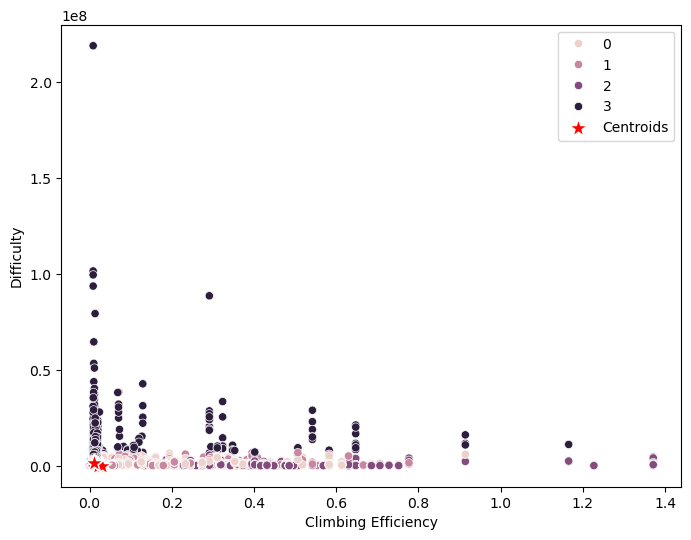

In [87]:
import matplotlib.pyplot as plt
# Create a single plot
plt.figure(figsize=(8, 6))

# Second scatter plot: for the numeric_dataset with KMeans labels
seaborn.scatterplot(data=numeric_dataset, x="climbing_efficiency", y="difficulty", hue=kmeans.labels_)

# Plot the NumPy data with a different marker style
seaborn.scatterplot(x=centers[:,8], y=centers[:, 10], label='Centroids', s=200, marker='*', c='r')


# Add labels and title
plt.xlabel('Climbing Efficiency')
plt.ylabel('Difficulty')

# Display the plot
plt.legend()
plt.show()

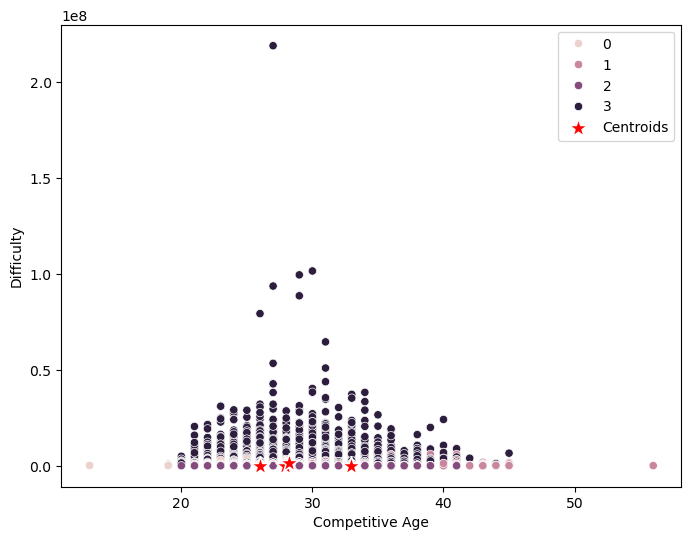

In [88]:
import matplotlib.pyplot as plt
# Create a single plot
plt.figure(figsize=(8, 6))

# Second scatter plot: for the numeric_dataset with KMeans labels
seaborn.scatterplot(data=numeric_dataset, x="competitive_age", y="difficulty", hue=kmeans.labels_)

# Plot the NumPy data with a different marker style
seaborn.scatterplot(x=centers[:,9], y=centers[:, 10], label='Centroids', s=200, marker='*', c='r')


# Add labels and title
plt.xlabel('Competitive Age')
plt.ylabel('Difficulty')

# Display the plot
plt.legend()
plt.show()

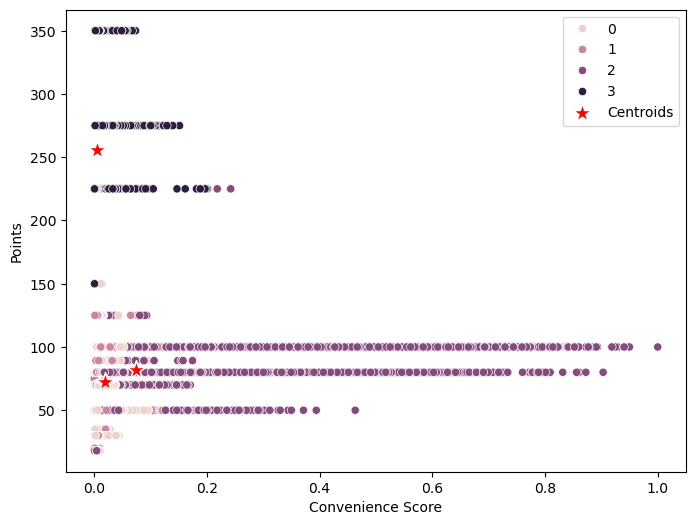

In [89]:
import matplotlib.pyplot as plt
# Create a single plot
plt.figure(figsize=(8, 6))

# Second scatter plot: for the numeric_dataset with KMeans labels
seaborn.scatterplot(data=numeric_dataset, x="convenience_score", y="points", hue=kmeans.labels_)

# Plot the NumPy data with a different marker style
seaborn.scatterplot(x=centers[:,11], y=centers[:, 0], label='Centroids', s=200, marker='*', c='r')


# Add labels and title
plt.xlabel('Convenience Score')
plt.ylabel('Points')

# Display the plot
plt.legend()
plt.show()